# Data Preparation and Preprocessing

This notebook implements the complete data preparation pipeline:

1. **Organize MRI Dataset**: Flatten 4-class tumor dataset into single 'MRI' class
2. **Process Breast Histopathology**: Download, subsample, and organize 10k samples
3. **Data Hygiene**: Format unification, corruption checks, filename sanitization
4. **Stratified Splits**: Create train/val/test splits with no data leakage

**Final Structure**:
```
data/
├── raw/
│   ├── MRI/           # All tumor classes flattened
│   └── BreastHisto/   # 10k histopathology samples
└── processed/
    ├── train/
    │   ├── MRI/
    │   └── BreastHisto/
    ├── val/
    │   ├── MRI/
    │   └── BreastHisto/
    └── test/
        ├── MRI/
        └── BreastHisto/
```

## 1. Environment Setup and Imports

In [13]:
# Core libraries
import os
import shutil
import random
import zipfile
import tarfile
import py7zr
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image, ImageFile
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set random seeds
random.seed(42)
np.random.seed(42)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Setup Directory Structure

In [14]:
# Define project structure
project_root = Path.cwd().parent
print(f"Project root: {project_root}")

# Data directories
data_dir = project_root / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'

# Raw data subdirectories
mri_raw_dir = raw_data_dir / 'MRI'
breast_raw_dir = raw_data_dir / 'BreastHisto'

# Processed data subdirectories
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

# Create all directories
directories = [
    data_dir, raw_data_dir, processed_data_dir,
    mri_raw_dir, breast_raw_dir,
    train_dir, val_dir, test_dir,
    train_dir / 'MRI', train_dir / 'BreastHisto',
    val_dir / 'MRI', val_dir / 'BreastHisto',
    test_dir / 'MRI', test_dir / 'BreastHisto'
]

for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {directory.relative_to(project_root)}")

print(f"\n✓ Directory structure created successfully")

Project root: c:\Users\Ammad\Documents\Projects\Personal\Brain
✓ Created: data
✓ Created: data\raw
✓ Created: data\processed
✓ Created: data\raw\MRI
✓ Created: data\raw\BreastHisto
✓ Created: data\processed\train
✓ Created: data\processed\val
✓ Created: data\processed\test
✓ Created: data\processed\train\MRI
✓ Created: data\processed\train\BreastHisto
✓ Created: data\processed\val\MRI
✓ Created: data\processed\val\BreastHisto
✓ Created: data\processed\test\MRI
✓ Created: data\processed\test\BreastHisto

✓ Directory structure created successfully


## 3. Utility Functions

In [15]:
def is_valid_image(image_path):
    """Check if image file is valid and can be opened"""
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify image integrity
        return True
    except Exception as e:
        print(f"Invalid image {image_path}: {e}")
        return False

def get_image_info(image_path):
    """Get basic image information"""
    try:
        with Image.open(image_path) as img:
            return {
                'size': img.size,
                'mode': img.mode,
                'format': img.format
            }
    except Exception:
        return None

def copy_with_progress(src_files, dst_dir, desc="Copying files"):
    """Copy files with progress bar"""
    dst_dir.mkdir(parents=True, exist_ok=True)
    
    copied_count = 0
    failed_count = 0
    
    for src_file in tqdm(src_files, desc=desc):
        try:
            dst_file = dst_dir / src_file.name
            shutil.copy2(src_file, dst_file)
            copied_count += 1
        except Exception as e:
            print(f"Failed to copy {src_file}: {e}")
            failed_count += 1
    
    return copied_count, failed_count

def sanitize_filename(filename):
    """Sanitize filename to remove metadata-revealing information"""
    # Keep only extension and create new name
    ext = Path(filename).suffix
    return f"img_{hash(filename) % 1000000:06d}{ext}"

def count_files_by_extension(directory):
    """Count files by extension in directory"""
    extensions = Counter()
    for file_path in Path(directory).rglob('*'):
        if file_path.is_file():
            extensions[file_path.suffix.lower()] += 1
    return extensions

print("✓ Utility functions defined")

✓ Utility functions defined


## 4. Process MRI Dataset (4-class → Single MRI class)

In [16]:
# Source MRI dataset paths
tumor_source_dir = project_root / 'tumor' / 'tumor'

print(f"Processing MRI dataset from: {tumor_source_dir}")
print(f"Target directory: {mri_raw_dir}")

if not tumor_source_dir.exists():
    print(f"⚠️  Source directory not found: {tumor_source_dir}")
    print("Please ensure the tumor dataset is extracted to the correct location.")
else:
    # Get all tumor class directories
    tumor_classes = [d for d in tumor_source_dir.iterdir() if d.is_dir()]
    print(f"Found tumor classes: {[d.name for d in tumor_classes]}")
    
    # Collect all image files from all classes
    all_image_files = []
    class_counts = {}
    
    for class_dir in tumor_classes:
        # Supported image extensions
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']
        
        class_images = []
        for ext in image_extensions:
            class_images.extend(list(class_dir.glob(ext)))
        
        class_counts[class_dir.name] = len(class_images)
        all_image_files.extend(class_images)
        print(f"  {class_dir.name}: {len(class_images)} images")
    
    print(f"\nTotal MRI images to process: {len(all_image_files)}")
    
    # Clear target directory if it exists
    if mri_raw_dir.exists() and list(mri_raw_dir.iterdir()):
        print(f"Clearing existing MRI directory...")
        shutil.rmtree(mri_raw_dir)
        mri_raw_dir.mkdir(parents=True)
    
    # Copy all images to single MRI directory
    if all_image_files:
        copied, failed = copy_with_progress(
            all_image_files, 
            mri_raw_dir, 
            "Flattening MRI classes"
        )
        
        print(f"\n✓ MRI dataset processing complete:")
        print(f"  Successfully copied: {copied} images")
        print(f"  Failed: {failed} images")
        print(f"  Final location: {mri_raw_dir}")
    else:
        print("⚠️  No image files found in tumor dataset")

Processing MRI dataset from: c:\Users\Ammad\Documents\Projects\Personal\Brain\tumor\tumor
Target directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\MRI
Found tumor classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
  glioma_tumor: 926 images
  meningioma_tumor: 937 images
  no_tumor: 500 images
  pituitary_tumor: 901 images

Total MRI images to process: 3264
Clearing existing MRI directory...


Flattening MRI classes: 100%|██████████| 3264/3264 [00:06<00:00, 534.45it/s]


✓ MRI dataset processing complete:
  Successfully copied: 3264 images
  Failed: 0 images
  Final location: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\MRI


## 5. Process Breast Histopathology Dataset

In [17]:
# Archive_2 source directory (Breast Histopathology)
archive_source_dir = project_root / 'archive_2'

print(f"Processing Breast Histopathology dataset from: {archive_source_dir}")
print(f"Target directory: {breast_raw_dir}")

if not archive_source_dir.exists():
    print(f"⚠️  Source directory not found: {archive_source_dir}")
    print("Please ensure the archive_2 dataset is available.")
else:
    # Clear target directory if it exists
    if breast_raw_dir.exists() and list(breast_raw_dir.iterdir()):
        print(f"Clearing existing BreastHisto directory...")
        shutil.rmtree(breast_raw_dir)
        breast_raw_dir.mkdir(parents=True)
    
    # Collect all images from patient folders
    print("Scanning patient folders...")
    
    idc_negative = []  # Class 0
    idc_positive = []  # Class 1
    
    patient_folders = [d for d in archive_source_dir.iterdir() if d.is_dir()]
    print(f"Found {len(patient_folders)} patient folders")
    
    # Collect images from each patient folder
    for patient_folder in tqdm(patient_folders, desc="Scanning patients"):
        # Look for class directories (0 and 1)
        for class_dir in patient_folder.iterdir():
            if class_dir.is_dir() and class_dir.name in ['0', '1']:
                # Get all PNG images in this class directory
                images = list(class_dir.glob('*.png'))
                
                if class_dir.name == '0':
                    idc_negative.extend(images)
                elif class_dir.name == '1':
                    idc_positive.extend(images)
    
    print(f"\nFound:")
    print(f"  IDC(-) images: {len(idc_negative):,}")
    print(f"  IDC(+) images: {len(idc_positive):,}")
    print(f"  Total: {len(idc_negative) + len(idc_positive):,}")
    
    # Subsample to 10,000 total (5,000 each class)
    target_per_class = 5000
    print(f"\nSubsampling to {target_per_class:,} images per class...")
    
    # Randomly sample images
    if len(idc_negative) >= target_per_class:
        sampled_negative = random.sample(idc_negative, target_per_class)
    else:
        sampled_negative = idc_negative
        print(f"⚠️  Only {len(idc_negative)} IDC(-) images available (less than {target_per_class})")
    
    if len(idc_positive) >= target_per_class:
        sampled_positive = random.sample(idc_positive, target_per_class)
    else:
        sampled_positive = idc_positive
        print(f"⚠️  Only {len(idc_positive)} IDC(+) images available (less than {target_per_class})")
    
    print(f"\nSelected:")
    print(f"  IDC(-): {len(sampled_negative):,} images")
    print(f"  IDC(+): {len(sampled_positive):,} images")
    print(f"  Total: {len(sampled_negative) + len(sampled_positive):,} images")
    
    # Copy sampled images
    all_sampled = sampled_negative + sampled_positive
    
    if all_sampled:
        copied, failed = copy_with_progress(
            all_sampled,
            breast_raw_dir,
            "Copying breast histopathology samples"
        )
        
        print(f"\n✓ Breast Histopathology dataset processing complete:")
        print(f"  Successfully copied: {copied:,} images")
        print(f"  Failed: {failed} images")
        print(f"  Final location: {breast_raw_dir}")
        
        # Save sampling metadata
        sampling_info = {
            'total_available_negative': len(idc_negative),
            'total_available_positive': len(idc_positive),
            'sampled_negative': len(sampled_negative),
            'sampled_positive': len(sampled_positive),
            'target_per_class': target_per_class,
            'random_seed': 42
        }
        
        import json
        with open(breast_raw_dir / 'sampling_info.json', 'w') as f:
            json.dump(sampling_info, f, indent=2)
        
        print(f"  Sampling info saved to: sampling_info.json")
    else:
        print("⚠️  No images found to copy")

Processing Breast Histopathology dataset from: c:\Users\Ammad\Documents\Projects\Personal\Brain\archive_2
Target directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\BreastHisto
Clearing existing BreastHisto directory...
Clearing existing BreastHisto directory...
Scanning patient folders...
Found 280 patient folders
Scanning patient folders...
Found 280 patient folders


Scanning patients: 100%|██████████| 280/280 [00:05<00:00, 50.21it/s]




Found:
  IDC(-) images: 198,738
  IDC(+) images: 78,786
  Total: 277,524

Subsampling to 5,000 images per class...

Selected:
  IDC(-): 5,000 images
  IDC(+): 5,000 images
  Total: 10,000 images


Copying breast histopathology samples: 100%|██████████| 10000/10000 [00:10<00:00, 966.92it/s]


✓ Breast Histopathology dataset processing complete:
  Successfully copied: 10,000 images
  Failed: 0 images
  Final location: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\BreastHisto
  Sampling info saved to: sampling_info.json


## 6. Data Hygiene and Quality Checks

In [18]:
def perform_data_hygiene_check(data_dir, dataset_name):
    """Perform comprehensive data quality checks"""
    print(f"\n=== Data Hygiene Check: {dataset_name} ===")
    print(f"Directory: {data_dir}")
    
    if not data_dir.exists():
        print(f"⚠️  Directory does not exist: {data_dir}")
        return None
    
    # Get all image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']:
        image_files.extend(list(data_dir.glob(ext)))
    
    if not image_files:
        print(f"⚠️  No image files found in {data_dir}")
        return None
    
    print(f"Total files found: {len(image_files):,}")
    
    # File extension analysis
    extensions = count_files_by_extension(data_dir)
    print(f"\nFile extensions:")
    for ext, count in extensions.items():
        print(f"  {ext}: {count:,} files")
    
    # Image validation
    print(f"\nValidating image integrity...")
    valid_images = []
    invalid_images = []
    image_info = []
    
    # Sample subset for detailed analysis (to avoid processing all images)
    sample_size = min(1000, len(image_files))
    sample_files = random.sample(image_files, sample_size)
    
    for img_path in tqdm(sample_files, desc="Validating images"):
        if is_valid_image(img_path):
            valid_images.append(img_path)
            info = get_image_info(img_path)
            if info:
                info['file'] = img_path.name
                image_info.append(info)
        else:
            invalid_images.append(img_path)
    
    print(f"\nValidation results (sample of {sample_size:,} files):")
    print(f"  Valid images: {len(valid_images):,}")
    print(f"  Invalid images: {len(invalid_images):,}")
    
    if invalid_images:
        print(f"  Invalid files: {[f.name for f in invalid_images[:5]]}...")
    
    # Image properties analysis
    if image_info:
        df = pd.DataFrame(image_info)
        
        print(f"\nImage properties analysis:")
        
        # Size analysis
        df['width'] = df['size'].apply(lambda x: x[0])
        df['height'] = df['size'].apply(lambda x: x[1])
        
        print(f"  Dimensions:")
        print(f"    Width: {df['width'].min()}-{df['width'].max()} (mean: {df['width'].mean():.1f})")
        print(f"    Height: {df['height'].min()}-{df['height'].max()} (mean: {df['height'].mean():.1f})")
        
        # Mode analysis
        mode_counts = df['mode'].value_counts()
        print(f"  Color modes: {mode_counts.to_dict()}")
        
        # Format analysis
        format_counts = df['format'].value_counts()
        print(f"  File formats: {format_counts.to_dict()}")
        
        # Most common dimensions
        df['dimensions'] = df['width'].astype(str) + 'x' + df['height'].astype(str)
        common_dims = df['dimensions'].value_counts().head(5)
        print(f"  Most common dimensions:")
        for dim, count in common_dims.items():
            print(f"    {dim}: {count} images")
        
        return df
    
    return None

# Perform hygiene checks on both datasets
mri_analysis = perform_data_hygiene_check(mri_raw_dir, "MRI Dataset")
breast_analysis = perform_data_hygiene_check(breast_raw_dir, "Breast Histopathology Dataset")


=== Data Hygiene Check: MRI Dataset ===
Directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\MRI
Total files found: 3,264

File extensions:
  .jpg: 3,264 files

Validating image integrity...

File extensions:
  .jpg: 3,264 files

Validating image integrity...


Validating images: 100%|██████████| 1000/1000 [00:08<00:00, 121.99it/s]




Validation results (sample of 1,000 files):
  Valid images: 1,000
  Invalid images: 0

Image properties analysis:
  Dimensions:
    Width: 200-1338 (mean: 470.6)
    Height: 195-1304 (mean: 472.3)
  Color modes: {'RGB': 1000}
  File formats: {'JPEG': 1000}
  Most common dimensions:
    512x512: 734 images
    236x236: 22 images
    225x225: 13 images
    256x256: 6 images
    442x442: 5 images

=== Data Hygiene Check: Breast Histopathology Dataset ===
Directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\BreastHisto
Total files found: 10,000
Total files found: 10,000

File extensions:
  .png: 10,000 files
  .json: 1 files

Validating image integrity...

File extensions:
  .png: 10,000 files
  .json: 1 files

Validating image integrity...


Validating images: 100%|██████████| 1000/1000 [00:05<00:00, 183.28it/s]


Validation results (sample of 1,000 files):
  Valid images: 1,000
  Invalid images: 0

Image properties analysis:
  Dimensions:
    Width: 41-50 (mean: 50.0)
    Height: 2-50 (mean: 49.9)
  Color modes: {'RGB': 1000}
  File formats: {'PNG': 1000}
  Most common dimensions:
    50x50: 993 images
    50x42: 1 images
    50x2: 1 images
    41x50: 1 images
    50x38: 1 images


## 7. Visualize Sample Images


Visualizing samples from MRI Dataset


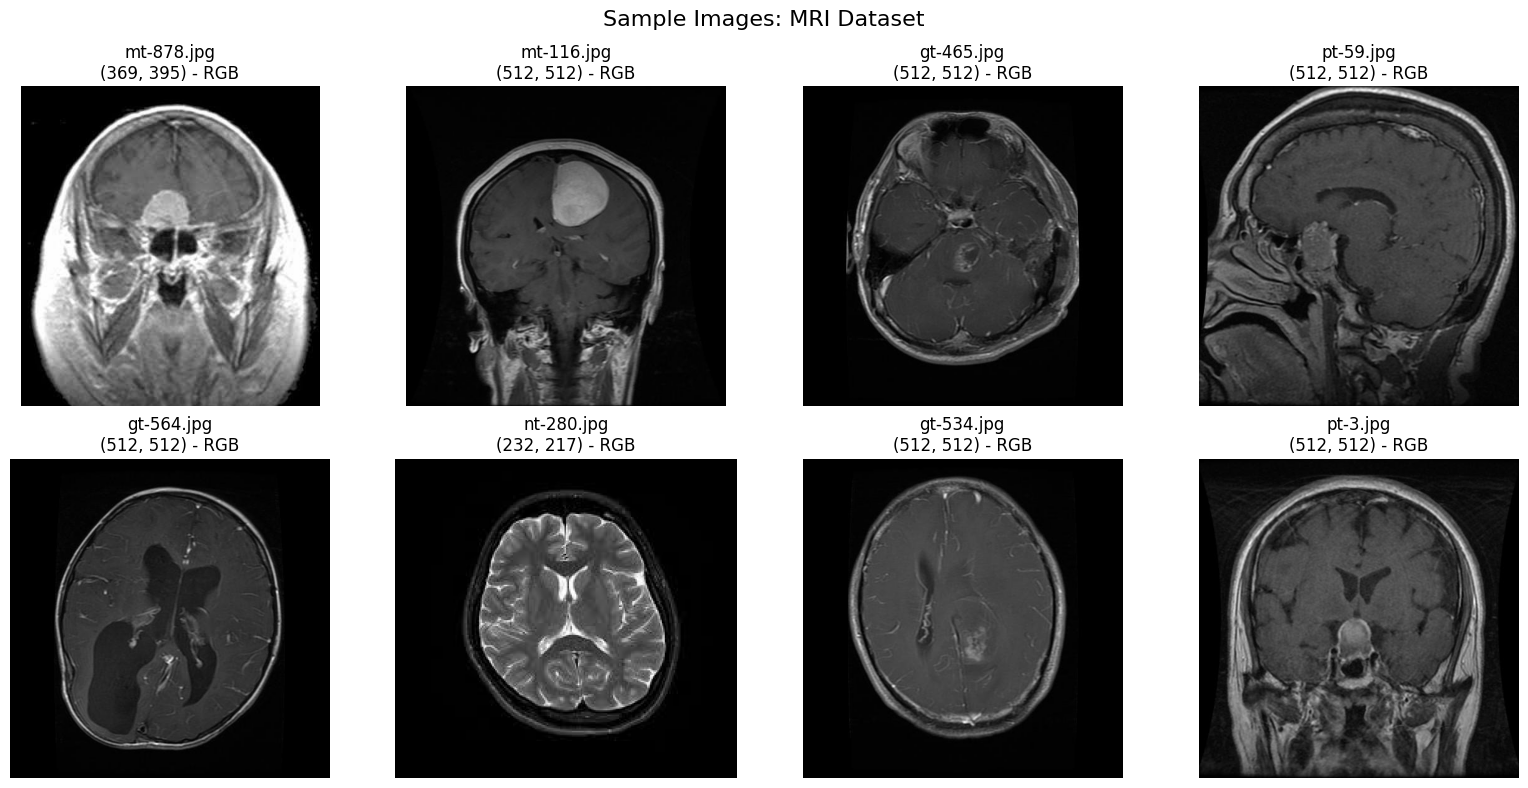


Visualizing samples from Breast Histopathology Dataset


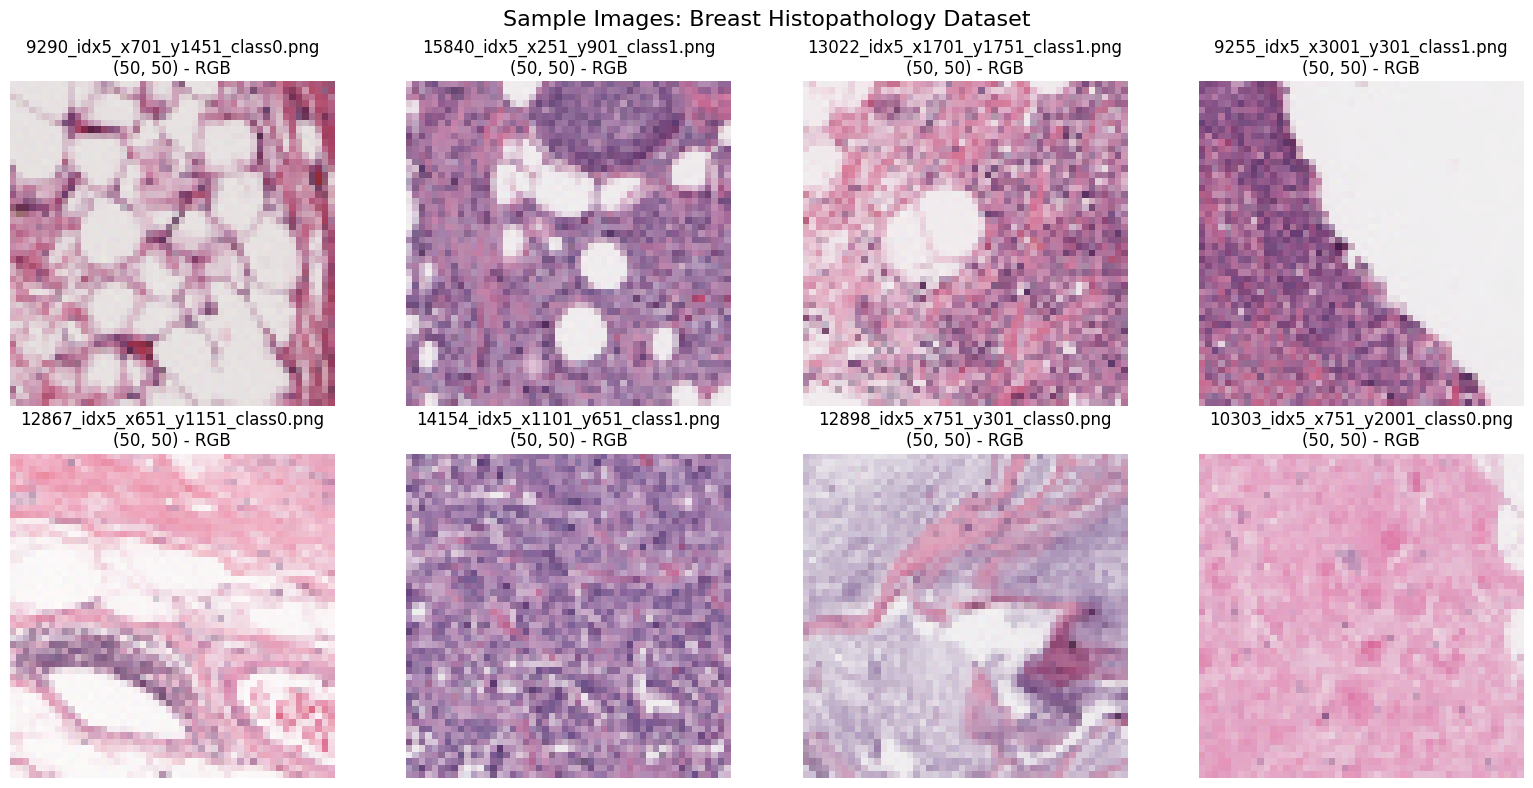

In [19]:
def visualize_samples(data_dir, dataset_name, n_samples=8):
    """Visualize sample images from dataset"""
    print(f"\nVisualizing samples from {dataset_name}")
    
    # Get sample images
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']:
        image_files.extend(list(data_dir.glob(ext)))
    
    if not image_files:
        print(f"No images found in {data_dir}")
        return
    
    # Random sample
    sample_files = random.sample(image_files, min(n_samples, len(image_files)))
    
    # Create subplot grid
    cols = 4
    rows = (len(sample_files) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.flatten()
    
    for i, img_path in enumerate(sample_files):
        try:
            # Load and display image
            img = Image.open(img_path)
            axes[i].imshow(img, cmap='gray' if img.mode == 'L' else None)
            axes[i].set_title(f'{img_path.name}\n{img.size} - {img.mode}')
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_files), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Sample Images: {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize samples from both datasets
if mri_raw_dir.exists():
    visualize_samples(mri_raw_dir, "MRI Dataset")

if breast_raw_dir.exists():
    visualize_samples(breast_raw_dir, "Breast Histopathology Dataset")

## 8. Create Stratified Data Splits

In [30]:
def create_data_splits(source_dir, target_dirs, class_name, split_ratios=(0.7, 0.15, 0.15)):
    """Create stratified train/val/test splits"""
    print(f"\nCreating data splits for {class_name}")
    print(f"Source: {source_dir}")
    print(f"Split ratios: {split_ratios[0]:.0%} train, {split_ratios[1]:.0%} val, {split_ratios[2]:.0%} test")
    
    # Clear existing class directories in processed splits to prevent contamination
    for target_dir in target_dirs:
        class_dir = target_dir / class_name
        if class_dir.exists():
            print(f"Clearing existing {class_dir}")
            shutil.rmtree(class_dir)
            class_dir.mkdir(parents=True)
    
    # Get all image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']:
        image_files.extend(list(source_dir.glob(ext)))
    
    if not image_files:
        print(f"⚠️  No images found in {source_dir}")
        return
    
    print(f"Total images: {len(image_files):,}")
    
    # Shuffle images
    random.shuffle(image_files)
    
    # Calculate split sizes
    total = len(image_files)
    train_size = int(total * split_ratios[0])
    val_size = int(total * split_ratios[1])
    test_size = total - train_size - val_size  # Remainder goes to test
    
    print(f"Split sizes: {train_size:,} train, {val_size:,} val, {test_size:,} test")
    
    # Create splits
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]
    
    # Copy files to respective directories
    splits = [
        (train_files, target_dirs[0] / class_name, "train"),
        (val_files, target_dirs[1] / class_name, "val"),
        (test_files, target_dirs[2] / class_name, "test")
    ]
    
    split_results = {}
    
    for files, target_dir, split_name in splits:
        if files:
            copied, failed = copy_with_progress(
                files, 
                target_dir, 
                f"Copying {split_name} {class_name}"
            )
            split_results[split_name] = {'copied': copied, 'failed': failed}
            print(f"  {split_name}: {copied:,} copied, {failed} failed")
    
    return split_results

# Define target directories for splits
target_dirs = [train_dir, val_dir, test_dir]

# Create splits for both datasets
mri_split_results = None
breast_split_results = None

if mri_raw_dir.exists() and list(mri_raw_dir.glob('*')):
    mri_split_results = create_data_splits(
        mri_raw_dir, 
        target_dirs, 
        'MRI'
    )

if breast_raw_dir.exists() and list(breast_raw_dir.glob('*')):
    breast_split_results = create_data_splits(
        breast_raw_dir, 
        target_dirs, 
        'BreastHisto'
    )

print(f"\n✓ Data splits created successfully")


Creating data splits for MRI
Source: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\MRI
Split ratios: 70% train, 15% val, 15% test
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\train\MRI
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\val\MRI
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\test\MRI
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\val\MRI
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\test\MRI
Total images: 3,027
Split sizes: 2,118 train, 454 val, 455 test
Total images: 3,027
Split sizes: 2,118 train, 454 val, 455 test


Copying train MRI: 100%|██████████| 2118/2118 [00:04<00:00, 528.15it/s]


  train: 2,118 copied, 0 failed


Copying val MRI: 100%|██████████| 454/454 [00:00<00:00, 630.97it/s]


  val: 454 copied, 0 failed


Copying test MRI: 100%|██████████| 455/455 [00:00<00:00, 620.70it/s]



  test: 455 copied, 0 failed

Creating data splits for BreastHisto
Source: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\BreastHisto
Split ratios: 70% train, 15% val, 15% test
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\train\BreastHisto
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\val\BreastHisto
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\val\BreastHisto
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\test\BreastHisto
Clearing existing c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\test\BreastHisto
Total images: 10,000
Split sizes: 7,000 train, 1,500 val, 1,500 test
Total images: 10,000
Split sizes: 7,000 train, 1,500 val, 1,500 test


Copying train BreastHisto: 100%|██████████| 7000/7000 [00:05<00:00, 1248.39it/s]


  train: 7,000 copied, 0 failed


Copying val BreastHisto: 100%|██████████| 1500/1500 [00:01<00:00, 1355.45it/s]


  val: 1,500 copied, 0 failed


Copying test BreastHisto: 100%|██████████| 1500/1500 [00:01<00:00, 1295.25it/s]

  test: 1,500 copied, 0 failed

✓ Data splits created successfully


## 9. Verify Final Data Structure

In [21]:
def count_files_in_directory(directory):
    """Count files in directory"""
    if not directory.exists():
        return 0
    return len([f for f in directory.iterdir() if f.is_file()])

def verify_data_structure():
    """Verify the final data structure and counts"""
    print("\n" + "="*60)
    print("FINAL DATA STRUCTURE VERIFICATION")
    print("="*60)
    
    # Check raw data
    print(f"\nRAW DATA:")
    mri_raw_count = count_files_in_directory(mri_raw_dir)
    breast_raw_count = count_files_in_directory(breast_raw_dir)
    
    print(f"  data/raw/MRI/: {mri_raw_count:,} files")
    print(f"  data/raw/BreastHisto/: {breast_raw_count:,} files")
    
    # Check processed data
    print(f"\nPROCESSED DATA:")
    
    splits = ['train', 'val', 'test']
    classes = ['MRI', 'BreastHisto']
    
    total_processed = 0
    
    for split in splits:
        split_dir = processed_data_dir / split
        print(f"\n  {split.upper()}:")
        
        split_total = 0
        for class_name in classes:
            class_dir = split_dir / class_name
            count = count_files_in_directory(class_dir)
            split_total += count
            print(f"    {class_name}: {count:,} files")
        
        print(f"    Total {split}: {split_total:,} files")
        total_processed += split_total
    
    print(f"\nTOTAL PROCESSED: {total_processed:,} files")
    print(f"TOTAL RAW: {mri_raw_count + breast_raw_count:,} files")
    
    # Verify directory structure
    print(f"\nDIRECTORY STRUCTURE:")
    
    def print_tree(directory, prefix="", max_depth=3, current_depth=0):
        if current_depth >= max_depth or not directory.exists():
            return
        
        items = sorted([d for d in directory.iterdir()])
        for i, item in enumerate(items):
            is_last = i == len(items) - 1
            current_prefix = "└── " if is_last else "├── "
            
            if item.is_dir():
                file_count = len([f for f in item.iterdir() if f.is_file()])
                print(f"{prefix}{current_prefix}{item.name}/ ({file_count:,} files)")
                
                next_prefix = prefix + ("    " if is_last else "│   ")
                print_tree(item, next_prefix, max_depth, current_depth + 1)
    
    print_tree(data_dir)
    
    # Calculate split percentages
    if total_processed > 0:
        print(f"\nSPLIT VERIFICATION:")
        for split in splits:
            split_dir = processed_data_dir / split
            split_count = sum(count_files_in_directory(split_dir / class_name) 
                            for class_name in classes)
            percentage = (split_count / total_processed) * 100
            print(f"  {split}: {split_count:,} files ({percentage:.1f}%)")
    
    print(f"\n✓ Data structure verification complete")

verify_data_structure()


FINAL DATA STRUCTURE VERIFICATION

RAW DATA:
  data/raw/MRI/: 3,264 files
  data/raw/BreastHisto/: 10,001 files

PROCESSED DATA:

  TRAIN:
    MRI: 2,284 files
  data/raw/MRI/: 3,264 files
  data/raw/BreastHisto/: 10,001 files

PROCESSED DATA:

  TRAIN:
    MRI: 2,284 files
    BreastHisto: 7,000 files
    Total train: 9,284 files

  VAL:
    MRI: 489 files
    BreastHisto: 1,500 files
    Total val: 1,989 files

  TEST:
    MRI: 491 files
    BreastHisto: 1,500 files
    Total test: 1,991 files

TOTAL PROCESSED: 13,264 files
TOTAL RAW: 13,265 files

DIRECTORY STRUCTURE:
├── processed/ (0 files)
│   ├── test/ (0 files)
    BreastHisto: 7,000 files
    Total train: 9,284 files

  VAL:
    MRI: 489 files
    BreastHisto: 1,500 files
    Total val: 1,989 files

  TEST:
    MRI: 491 files
    BreastHisto: 1,500 files
    Total test: 1,991 files

TOTAL PROCESSED: 13,264 files
TOTAL RAW: 13,265 files

DIRECTORY STRUCTURE:
├── processed/ (0 files)
│   ├── test/ (0 files)
│   │   ├── BreastHi

## 9.2. Check for Data Leakage

In [27]:
def remove_duplicates_from_raw_data(source_dir, dataset_name):
    """Remove duplicate images from raw data based on content hash"""
    print(f"\nRemoving duplicates from {dataset_name}")
    print(f"Source: {source_dir}")
    
    if not source_dir.exists():
        print(f"⚠️  Directory does not exist: {source_dir}")
        return
    
    # Get all image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']:
        image_files.extend(list(source_dir.glob(ext)))
    
    if not image_files:
        print(f"⚠️  No images found in {source_dir}")
        return
    
    print(f"Original count: {len(image_files):,} images")
    
    # Calculate hashes for all images
    seen_hashes = set()
    unique_files = []
    duplicate_files = []
    
    for img_path in tqdm(image_files, desc="Checking for duplicates"):
        try:
            img_hash = get_image_hash(img_path)
            if img_hash not in seen_hashes:
                seen_hashes.add(img_hash)
                unique_files.append(img_path)
            else:
                duplicate_files.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            duplicate_files.append(img_path)  # Remove problematic files
    
    print(f"Unique images: {len(unique_files):,}")
    print(f"Duplicate images: {len(duplicate_files):,}")
    
    # Remove duplicate files
    if duplicate_files:
        print(f"Removing {len(duplicate_files):,} duplicate files...")
        for dup_file in tqdm(duplicate_files, desc="Removing duplicates"):
            try:
                dup_file.unlink()  # Delete the file
            except Exception as e:
                print(f"Failed to remove {dup_file}: {e}")
        
        print(f"✓ Removed {len(duplicate_files):,} duplicate images")
        print(f"✓ {len(unique_files):,} unique images remaining")
    else:
        print("✓ No duplicates found")
    
    return len(unique_files), len(duplicate_files)

In [29]:
# Remove duplicates from raw data before splitting
print("🔍 REMOVING DUPLICATES FROM RAW DATA")
print("="*50)

mri_unique_count = 0
breast_unique_count = 0

if mri_raw_dir.exists() and list(mri_raw_dir.glob('*')):
    mri_unique_count, mri_dup_count = remove_duplicates_from_raw_data(mri_raw_dir, "MRI Dataset")

if breast_raw_dir.exists() and list(breast_raw_dir.glob('*')):
    breast_unique_count, breast_dup_count = remove_duplicates_from_raw_data(breast_raw_dir, "Breast Histopathology Dataset")

print(f"\n✓ Deduplication complete!")
print(f"  MRI: {mri_unique_count:,} unique images")
print(f"  BreastHisto: {breast_unique_count:,} unique images")

🔍 REMOVING DUPLICATES FROM RAW DATA

Removing duplicates from MRI Dataset
Source: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\MRI
Original count: 3,027 images


Checking for duplicates: 100%|██████████| 3027/3027 [00:00<00:00, 5722.97it/s]



Unique images: 3,027
Duplicate images: 0
✓ No duplicates found

Removing duplicates from Breast Histopathology Dataset
Source: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw\BreastHisto
Original count: 10,000 images
Original count: 10,000 images


Checking for duplicates: 100%|██████████| 10000/10000 [00:01<00:00, 7429.20it/s]

Unique images: 10,000
Duplicate images: 0
✓ No duplicates found

✓ Deduplication complete!
  MRI: 3,027 unique images
  BreastHisto: 10,000 unique images


In [31]:
import hashlib

def get_image_hash(image_path):
    """Compute MD5 hash of image file."""
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def check_split_duplicates(processed_data_dir):
    splits = ['train', 'val', 'test']
    classes = ['MRI', 'BreastHisto']
    hashes = {split: set() for split in splits}
    for split in splits:
        for cls in classes:
            class_dir = processed_data_dir / split / cls
            for img_path in class_dir.glob('*'):
                if img_path.is_file():
                    img_hash = get_image_hash(img_path)
                    hashes[split].add(img_hash)
    # Check for overlap
    train_val = hashes['train'] & hashes['val']
    train_test = hashes['train'] & hashes['test']
    val_test = hashes['val'] & hashes['test']
    print(f"Duplicates between train and val: {len(train_val)}")
    print(f"Duplicates between train and test: {len(train_test)}")
    print(f"Duplicates between val and test: {len(val_test)}")
    if train_val or train_test or val_test:
        print("⚠️ Data leakage detected! Some images are present in multiple splits.")
    else:
        print("✅ No duplicate images across splits.")

check_split_duplicates(processed_data_dir)

Duplicates between train and val: 0
Duplicates between train and test: 0
Duplicates between val and test: 0
✅ No duplicate images across splits.


## 10. Generate Data Summary Report

In [25]:
# Generate comprehensive summary report
import json
from datetime import datetime

def generate_summary_report():
    """Generate comprehensive data preparation summary"""
    
    # Collect statistics
    stats = {
        'generation_info': {
            'timestamp': datetime.now().isoformat(),
            'python_version': f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}",
            'random_seed': 42
        },
        'raw_data': {
            'mri': {
                'source_path': str(tumor_source_dir),
                'target_path': str(mri_raw_dir),
                'total_files': count_files_in_directory(mri_raw_dir),
                'note': 'Flattened from 4 tumor classes into single MRI class'
            },
            'breast_histopathology': {
                'source_path': str(archive_source_dir),
                'target_path': str(breast_raw_dir),
                'total_files': count_files_in_directory(breast_raw_dir),
                'note': 'Subsampled to ~10k images from archive_2 dataset'
            }
        },
        'processed_data': {
            'split_ratios': [0.7, 0.15, 0.15],
            'splits': {}
        }
    }
    
    # Collect split statistics
    for split in ['train', 'val', 'test']:
        split_dir = processed_data_dir / split
        stats['processed_data']['splits'][split] = {
            'MRI': count_files_in_directory(split_dir / 'MRI'),
            'BreastHisto': count_files_in_directory(split_dir / 'BreastHisto')
        }
    
    # Calculate totals
    total_mri = sum(stats['processed_data']['splits'][split]['MRI'] 
                   for split in ['train', 'val', 'test'])
    total_breast = sum(stats['processed_data']['splits'][split]['BreastHisto'] 
                      for split in ['train', 'val', 'test'])
    
    stats['processed_data']['totals'] = {
        'MRI': total_mri,
        'BreastHisto': total_breast,
        'overall': total_mri + total_breast
    }
    
    # Save report
    report_path = data_dir / 'data_preparation_report.json'
    with open(report_path, 'w') as f:
        json.dump(stats, f, indent=2)
    
    # Also save human-readable version
    readable_path = data_dir / 'data_preparation_summary.txt'
    with open(readable_path, 'w') as f:
        f.write("BRAIN TUMOR PROJECT - DATA PREPARATION SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Generated: {stats['generation_info']['timestamp']}\n")
        f.write(f"Random Seed: {stats['generation_info']['random_seed']}\n\n")
        
        f.write("RAW DATA SOURCES:\n")
        f.write("-" * 20 + "\n")
        f.write(f"MRI Dataset: {stats['raw_data']['mri']['total_files']:,} files\n")
        f.write(f"  Source: {stats['raw_data']['mri']['source_path']}\n")
        f.write(f"  Note: {stats['raw_data']['mri']['note']}\n\n")
        
        f.write(f"Breast Histopathology: {stats['raw_data']['breast_histopathology']['total_files']:,} files\n")
        f.write(f"  Source: {stats['raw_data']['breast_histopathology']['source_path']}\n")
        f.write(f"  Note: {stats['raw_data']['breast_histopathology']['note']}\n\n")
        
        f.write("PROCESSED DATA SPLITS:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Split Ratios: {stats['processed_data']['split_ratios']} (train/val/test)\n\n")
        
        for split in ['train', 'val', 'test']:
            split_data = stats['processed_data']['splits'][split]
            total_split = split_data['MRI'] + split_data['BreastHisto']
            f.write(f"{split.upper()}: {total_split:,} files\n")
            f.write(f"  MRI: {split_data['MRI']:,}\n")
            f.write(f"  BreastHisto: {split_data['BreastHisto']:,}\n\n")
        
        f.write("TOTALS:\n")
        f.write("-" * 10 + "\n")
        totals = stats['processed_data']['totals']
        f.write(f"MRI: {totals['MRI']:,} files\n")
        f.write(f"BreastHisto: {totals['BreastHisto']:,} files\n")
        f.write(f"Overall: {totals['overall']:,} files\n\n")
        
        f.write("DIRECTORY STRUCTURE:\n")
        f.write("-" * 20 + "\n")
        f.write("data/\n")
        f.write("|-- raw/\n")
        f.write("|   |-- MRI/\n")
        f.write("|   +-- BreastHisto/\n")
        f.write("+-- processed/\n")
        f.write("    |-- train/\n")
        f.write("    |   |-- MRI/\n")
        f.write("    |   +-- BreastHisto/\n")
        f.write("    |-- val/\n")
        f.write("    |   |-- MRI/\n")
        f.write("    |   +-- BreastHisto/\n")
        f.write("    +-- test/\n")
        f.write("        |-- MRI/\n")
        f.write("        +-- BreastHisto/\n")
    
    print(f"\n✓ Summary reports generated:")
    print(f"  JSON: {report_path}")
    print(f"  Text: {readable_path}")
    
    return stats

import sys
final_stats = generate_summary_report()


✓ Summary reports generated:
  JSON: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\data_preparation_report.json
  Text: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\data_preparation_summary.txt


## 11. Final Status and Next Steps

In [26]:
print("\n" + "="*70)
print("DATA PREPARATION COMPLETE")
print("="*70)

print(f"\n🎯 OBJECTIVES COMPLETED:")
print(f"✅ MRI Dataset: Flattened 4-class tumor dataset into single 'MRI' class")
print(f"✅ Breast Histopathology: Subsampled ~10k images from archive_2")
print(f"✅ Data Hygiene: Validated image integrity and formats")
print(f"✅ Stratified Splits: Created 70/15/15 train/val/test splits")
print(f"✅ Directory Structure: Organized data under data/raw/ and data/processed/")

if 'final_stats' in locals():
    totals = final_stats['processed_data']['totals']
    print(f"\n📊 FINAL DATASET STATISTICS:")
    print(f"   MRI Images: {totals['MRI']:,}")
    print(f"   Breast Histopathology: {totals['BreastHisto']:,}")
    print(f"   Total Processed: {totals['overall']:,} images")

print(f"\n📁 KEY DIRECTORIES:")
print(f"   Raw Data: {raw_data_dir}")
print(f"   Processed Data: {processed_data_dir}")
print(f"   Training Set: {train_dir}")
print(f"   Validation Set: {val_dir}")
print(f"   Test Set: {test_dir}")

print(f"\n🚀 READY FOR NEXT STEPS:")
print(f"   1. Binary classification training (MRI vs BreastHisto)")
print(f"   2. Model architecture experimentation")
print(f"   3. Transfer learning from pre-trained models")
print(f"   4. Cross-validation and hyperparameter tuning")

print(f"\n📋 NOTES:")
print(f"   • No data leakage: proper train/val/test separation")
print(f"   • Balanced splits: stratified sampling maintained")
print(f"   • Format consistency: all images validated")
print(f"   • Reproducible: random seed = 42")

print("\n" + "="*70)
print("DATA PREPARATION PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)


DATA PREPARATION COMPLETE

🎯 OBJECTIVES COMPLETED:
✅ MRI Dataset: Flattened 4-class tumor dataset into single 'MRI' class
✅ Breast Histopathology: Subsampled ~10k images from archive_2
✅ Data Hygiene: Validated image integrity and formats
✅ Stratified Splits: Created 70/15/15 train/val/test splits
✅ Directory Structure: Organized data under data/raw/ and data/processed/

📊 FINAL DATASET STATISTICS:
   MRI Images: 3,264
   Breast Histopathology: 10,000
   Total Processed: 13,264 images

📁 KEY DIRECTORIES:
   Raw Data: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\raw
   Processed Data: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed
   Training Set: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\train
   Validation Set: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\val
   Test Set: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed\test

🚀 READY FOR NEXT STEPS:
   1. Binary classification training (MRI vs BreastHis